# Used Car Price Prediction
## Feature Cleaning & Preprocessing

### Objective
This notebook focuses on cleaning and preprocessing feature columns for the
used car price prediction regression problem.

Target variable preprocessing (price cleaning, outlier removal, and log
transformation) has already been finalized in a separate notebook. This notebook
assumes a target-cleaned dataset as input and concentrates only on feature-level
decisions.

### Load Target-Cleaned Dataset

This notebook uses the dataset produced after target variable cleaning
(zero-price removal, outlier handling, and log transformation).

All feature preprocessing steps start from this consistent, cleaned state.


In [1]:
import pandas as pd
import numpy as np

# Load target-cleaned data
df = pd.read_csv("../data/interim/vehicles_target_cleaned.csv")

### Initial Feature Overview

Before applying any feature-level cleaning decisions, we inspect the dataset
structure to understand available features, data types, and missingness.

No transformations are applied at this stage.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392020 entries, 0 to 392019
Data columns (total 27 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            392020 non-null  int64  
 1   url           392020 non-null  object 
 2   region        392020 non-null  object 
 3   region_url    392020 non-null  object 
 4   price         392020 non-null  int64  
 5   year          390905 non-null  float64
 6   manufacturer  376197 non-null  object 
 7   model         387507 non-null  object 
 8   condition     241892 non-null  object 
 9   cylinders     232485 non-null  object 
 10  fuel          389434 non-null  object 
 11  odometer      389752 non-null  float64
 12  title_status  384329 non-null  object 
 13  transmission  390207 non-null  object 
 14  VIN           240518 non-null  object 
 15  drive         272291 non-null  object 
 16  size          110552 non-null  object 
 17  type          306551 non-null  object 
 18  pain

#### Observations
- 

### Handling Missing Values: Year

The `year` feature is directly related to vehicle age and has a strong influence
on price. Because only a very small fraction of rows have missing values for
this column, dropping these rows is preferred over imputation to avoid
introducing bias into the age–price relationship.

In [3]:
# Drop rows with missing year
df = df.dropna(subset=['year'])

#### Observations
- Rows with missing `year` values were dropped.
- The proportion of dropped rows is negligible relative to dataset size.
- Preserving a clean and reliable vehicle age signal is prioritized over
  retaining a small number of incomplete records.

### Handling Missing Values: Odometer

The `odometer` feature is a strong proxy for vehicle usage and directly affects
price. While the column contains missing values, dropping these rows would lead
to significant data loss.

Because mileage is right-skewed, median imputation is preferred over mean
imputation to preserve a realistic central tendency.

In [4]:
# Median imputation for odometer
odometer_median = df['odometer'].median()
df['odometer'] = df['odometer'].fillna(odometer_median)

In [5]:
df['odometer'].isna().sum()

np.int64(0)

#### Observations
- Missing `odometer` values were imputed using the median.
- Median imputation avoids distortion caused by the right-skewed mileage
  distribution.
- This preserves dataset size while maintaining a stable usage–price signal.

### Odometer: Distribution, Invalid Values, and Outlier Handling

In [6]:
df['odometer'].describe()

count    3.909050e+05
mean     9.913574e+04
std      2.052597e+05
min      0.000000e+00
25%      3.904400e+04
50%      8.771250e+04
75%      1.354000e+05
max      1.000000e+07
Name: odometer, dtype: float64

In [7]:
# Check invalid values
(df['odometer'] <= 0).sum()

np.int64(1093)

In [8]:
# Check extreme upper values
df['odometer'].quantile([0.95, 0.99, 0.995, 0.999])

0.950     205396.4
0.990     280000.0
0.995     347000.0
0.999    1111120.6
Name: odometer, dtype: float64

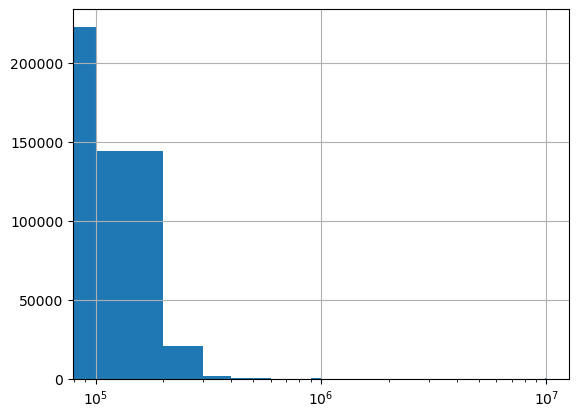

In [9]:
import matplotlib.pyplot as plt
df['odometer'].hist(bins=100)
plt.xscale('log')

In [10]:
# Treat zero mileage as invalid
df.loc[df['odometer'] == 0, 'odometer'] = np.nan

# Re-impute after fixing invalid zeros
odometer_median = df['odometer'].median()
df['odometer'] = df['odometer'].fillna(odometer_median)

# Cap extreme upper outliers
odometer_cap = df['odometer'].quantile(0.995)
df['odometer'] = df['odometer'].clip(upper=odometer_cap)

#### Observations
- A small number of zero-mileage entries were identified and treated as invalid.
- The odometer distribution is heavily right-skewed with extreme upper outliers.
- Zero values were replaced and median-imputed, and extreme values were capped
  at the 99.5th percentile to stabilize the mileage–price relationship.

### Handling Missing Values: Manufacturer

The `manufacturer` feature has a strong influence on vehicle price. However,
dropping rows with missing manufacturer information would result in unnecessary
data loss, and imputing an existing brand would introduce incorrect signal.

Missing values are therefore filled with an explicit `"unknown"` category.

In [11]:
df['manufacturer'] = df['manufacturer'].fillna('unknown')

#### Observations
- Missing manufacturer values were filled with an explicit `"unknown"` category.
- This preserves dataset size while avoiding the introduction of incorrect brand
  information.
- The model can now learn whether missing manufacturer information itself carries
  any price signal.
  